# Example 7: Running PARC for clustering analysis of Covid-19 scRNA cells

### Introduction
Parc is a fast clustering algorithm designed to effectively cluster heterogeneity in large single
cell data. We show how PARC enables downstream analysis on the recent dataset published by
[Liao. et al (2020)](https://www.nature.com/articles/s41591-020-0901-9).

### Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import warnings
import pathlib
# from numba.errors import NumbaPerformanceWarning
import numpy as np
import pandas as pd
import scanpy as sc
import parc
import harmonypy as hm
import seaborn as sns
import umap.umap_ as umap

### Download the Data

The data is available on [GEO GSE145926](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926) with each of the 12 patients in a separate .h5 file. 
The result should be a matrix of shape (n_cells x n_genes) (108230, 33538).

In [4]:
# Set the directory by replacing {PATH/TO/PARC}
DATA_DIR = "{PATH/TO/DATA}/"

data_files = [
    pathlib.Path(DATA_DIR, "GSM4475051_C148_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4475052_C149_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4475053_C152_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4475048_C51_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4475049_C52_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4339769_C141_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4339770_C142_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4339771_C143_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4339772_C144_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4475050_C100_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4339773_C145_filtered_feature_bc_matrix.h5"),
    pathlib.Path(DATA_DIR, "GSM4339774_C146_filtered_feature_bc_matrix.h5")
]  

In [5]:

patient_types =['S4','S5','S6','HC1','HC2','M1','M2','S2','M3','HC3','S1','S3']
patient_health_statuses = ['S','S','S','H','H','M','M','S','M','H','S','S']

for i, patient_type, patient_health, file_path in zip(range(len(patient_types)), patient_types, patient_health_statuses, data_files):
    ann_data_patient = sc.read_10x_h5(file_path)
    if i == 0:
        ann_data_patient.obs['patient_type'] = [patient_type] * ann_data_patient.shape[0]
        ann_data_patient.obs['patient_health'] = [patient_health] * ann_data_patient.shape[0]
        ann_data_patient.var_names_make_unique()
        ann_data = ann_data_patient
        
    else:
        ann_data_patient.var_names_make_unique()
        ann_data_patient.obs['patient_type'] = [patient_type] * ann_data_patient.shape[0]
        ann_data_patient.obs['patient_health'] = [patient_health] * ann_data_patient.shape[0]
        ann_data = ann_data.concatenate(ann_data_patient, join='inner') # we want the genes in common
   

In [6]:
print(
    "Annotated data observations (first 10 rows):\n"
    f"{ann_data.obs.iloc[0:10]}"
)

Annotated data observations (first 10 rows):
                                         patient_type patient_health batch
AAACCTGAGAGAACAG-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACCTGAGCTGCCCA-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACCTGAGGAATCGC-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACCTGGTGGTACAG-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACCTGTCCAGAAGG-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACCTGTCCAGTAGT-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACCTGTCTGGGCCA-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACGGGAGATCCCAT-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACGGGCACGAGGTA-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0
AAACGGGGTACATCCA-1-0-0-0-0-0-0-0-0-0-0-0           S4              S     0


### Filtering and pre-processing

Following the filters used by Liao et.al (2020) and removing cells with mitochondrial gene proportion > 0.1. 
After filtering the n_cells = 63753 and n_genes = 25668.

In [7]:
min_cells = 3 
min_genes = 200
max_genes = 6000
min_counts = 1000

sc.pp.filter_genes(ann_data, min_cells=min_cells)  # only consider genes expressed in more than min_cells
sc.pp.filter_cells(ann_data, min_genes=min_genes) # only consider cells with more than min_genes
sc.pp.filter_cells(ann_data, max_genes=max_genes) # only consider cells with less than max_cells
sc.pp.filter_cells(ann_data, min_counts=min_counts) # only consider cells with more than min_counts

In [8]:
mito_genes = ann_data.var_names.str.startswith('MT-')
ann_data.obs['percent_mito'] = np.sum(ann_data[:, mito_genes].X, axis=1).A1 / np.sum(ann_data.X, axis=1).A1
ann_data = ann_data[ann_data.obs.percent_mito < 0.1, :] # filter cells with high mito

ann_data.obs['n_counts'] = ann_data.X.sum(axis=1).A1 # add the total counts per cell as observations-annotation to ann_data

print(f"Shape after filtering: {ann_data.shape}")

Shape after filtering: (63753, 25668)


In [9]:
sc.pp.normalize_per_cell(ann_data, key_n_counts='n_counts_all' )  # normalize with total UMI count per cell
sc.pp.log1p(ann_data)
ann_data.raw = ann_data
adata_beforeHVG = ann_data.copy()

### Harmony PCA to integrate the batches

In [10]:
n_comps_pca = 50
n_top_genes = 2000

# select HVG
filter_result = sc.pp.filter_genes_dispersion(
    ann_data.X,
    flavor='cell_ranger',
    n_top_genes=n_top_genes,
    log=False
) # select highly-variable genes

print(filter_result, filter_result.gene_subset)

ann_data = ann_data[:, filter_result.gene_subset]  # subset the genes

sc.pp.scale(ann_data, max_value=5)  # scale to unit variance and shift to zero mean. Clip values exceeding standard deviation 10.
sc.tl.pca(ann_data, svd_solver='arpack', n_comps=n_comps_pca)

[(False, 7.0834276e-04, 0.6848484 ,  0.27154154)
 (False, 7.4105184e-05, 0.6147516 ,  0.4668431 )
 (False, 2.5824214e-05, 0.9647063 ,  1.7608302 ) ...
 ( True, 1.3939296e-03, 3.886037  , 32.046425  )
 ( True, 2.6764904e-04, 1.3681211 ,  4.5427337 )
 (False, 7.9755653e-03, 0.61826074,  1.0558165 )] [False False False ...  True  True False]


In [11]:
df_meta = pd.DataFrame()
df_meta['patient_type'] = ann_data.obs['patient_type']
harmony_out = hm.run_harmony(ann_data.obsm['X_pca'], df_meta, 'patient_type')
res = harmony_out.Z_corr.T
print(f"Size of harmony corrected output: {res.shape}")

2024-09-02 16:18:35,124 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2024-09-02 16:18:52,087 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-02 16:18:52,350 - harmonypy - INFO - Iteration 1 of 10
2024-09-02 16:19:16,735 - harmonypy - INFO - Iteration 2 of 10
2024-09-02 16:19:37,594 - harmonypy - INFO - Iteration 3 of 10
2024-09-02 16:19:58,838 - harmonypy - INFO - Converged after 3 iterations


Size of harmony corrected output: (63753, 50)


### Run PARC clustering and get PARC-UMAP embedding 

We construct the UMAP embedding my providing UMAP that KNN graph constructed in PARC.
The PARC-UMAP implementation is runtime-efficient, and has significantly lower RAM usage.

[MESSAGE]: Input data has shape 63753 (samples) x 50 (features)
[MESSAGE]: Creating knn_struct...
[MESSAGE]: Starting local pruning based on Euclidean distance metric at 3 standard deviations above the mean
[MESSAGE]: Starting global pruning...
[MESSAGE]: Creating graph with 924364 edges and 63753 nodes...
[MESSAGE]: Starting Leiden community detection...
[MESSAGE]: Leiden algorithm find partition: partition type = ModularityVertexPartition
[MESSAGE]: 
Community 0 is not too large and has size:
13077 <= large_community_factor * n_samples = 0.4 * 63753 = 25501.2
Skipping large community expansion.
[MESSAGE]: Starting small community detection...
[MESSAGE]: Community 27 is a small community with population 2
[MESSAGE]: Community 28 is a small community with population 2
[MESSAGE]: Community 29 is a small community with population 2
[MESSAGE]: Community 30 is a small community with population 2
[MESSAGE]: Community 31 is a small community with population 2
[MESSAGE]: Community 32 is a sma

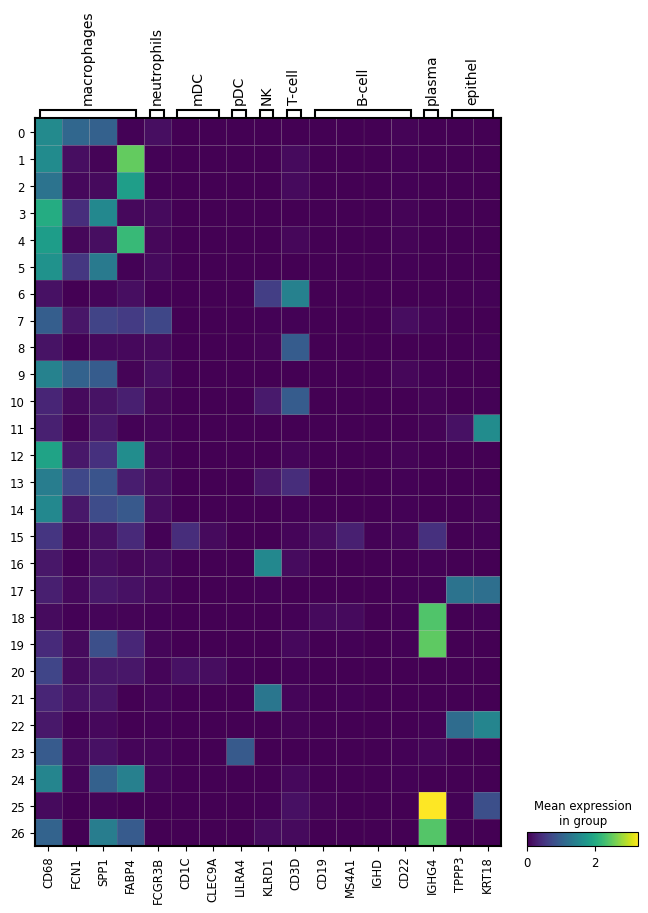

[MESSAGE]: a: 1.5769434604035877, b: 0.8950608780665811, spread: 1.0, dist: 0.1


0it [00:00, ?it/s]


In [12]:
parc_model = parc.PARC(res, random_seed=42)
parc_model.run_parc()
ann_data.obs['parc'] = [str(cluster) for cluster in parc_model.y_data_pred]

marker_genes = {
    "macrophages": ['CD68','FCN1','SPP1','FABP4'],
    "neutrophils": ['FCGR3B'],
    "mDC": ['CD1C', 'CLEC9A'],
    "pDC": ['LILRA4'],
    "NK": ['KLRD1'], "T-cell": ['CD3D'],
    "B-cell": ['CD19','MS4A1','IGHD', 'CD22'],
    "plasma": ['IGHG4'],  # CD19 doesnt show up for B
    "epithel": ['TPPP3', 'KRT18']
}

print('Plot cluster average expression of marker genes')
ax_mat = sc.pl.matrixplot(ann_data, marker_genes, groupby='parc')
graph = parc_model.create_knn_graph()
# umap_embedding= parc_model.run_umap_hnsw(
#     x_data=res,
#     graph=graph,
#     random_state_seed=1
# )
umap_embedding = umap.UMAP(n_components=2).fit_transform(res)

ENSG00000129226 in var_names: False
Cd68 in var_names: False
CD68 in var_names: False
SCARD1 in var_names: False
GP110 in var_names: False
LAMP4 in var_names: False
Gp110 in var_names: False
SPP1 in var_names: True
Plot cluster average expression of marker genes


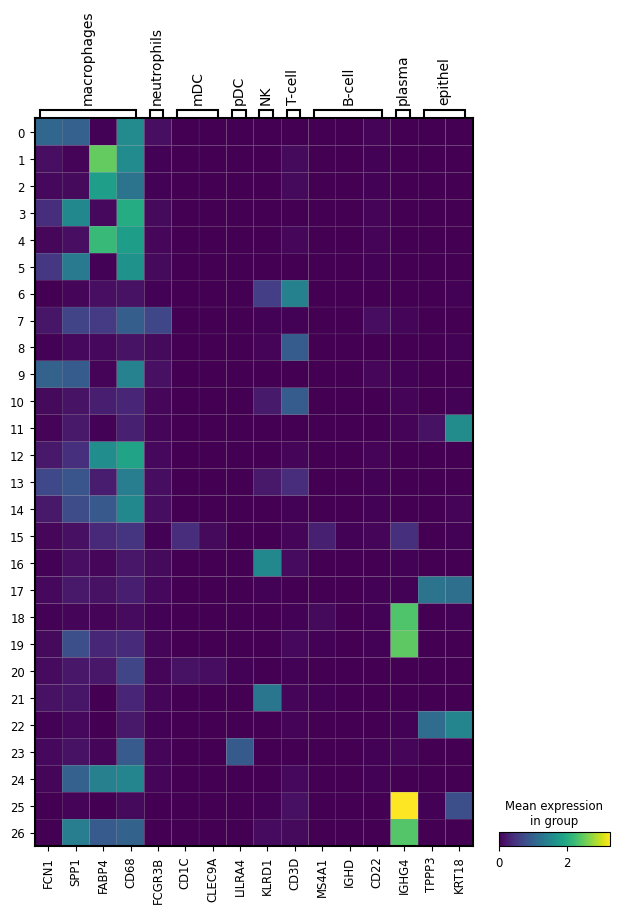

In [13]:
marker_genes = {
    "macrophages": ['FCN1','SPP1','FABP4','CD68'],
    "neutrophils": ['FCGR3B'],
    "mDC": ['CD1C', 'CLEC9A'],
    "pDC": ['LILRA4'],
    "NK": ['KLRD1'],
    "T-cell": ['CD3D'],
    "B-cell": ['MS4A1','IGHD', 'CD22'],
    "plasma": ['IGHG4'],  # CD19 doesnt show up for B
    "epithel": ['TPPP3', 'KRT18'],
    # "macrophages": ['FCN1','SPP1','FABP4','CD68']
}
    
for var_name in ['ENSG00000129226','Cd68', 'CD68', 'SCARD1','GP110','LAMP4','Gp110','SPP1']:
    print(f"{var_name} in var_names: {var_name in ann_data.var_names}")

print('Plot cluster average expression of marker genes')
ax_mat = sc.pl.matrixplot(ann_data, marker_genes, groupby='parc')


### Marker gene expression of macrophage and non-macrophage clusters 

Compute average cluster level gene expressions and sort those with high cd68 as macrophage clusters 
Identify the cluster composition in terms of H, M and S to label each cluster as predominantly H, M or S

categories: H1, H2, H4, etc.
var_group_labels: Healthy, Moderate, Severe


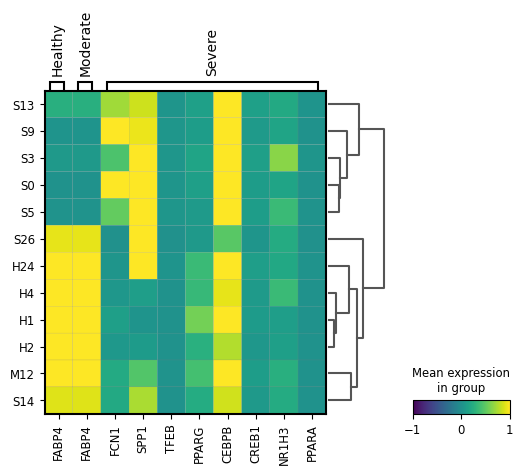

categories: H15, M6, S7, etc.
var_group_labels: mDC, pDC, NK, etc.


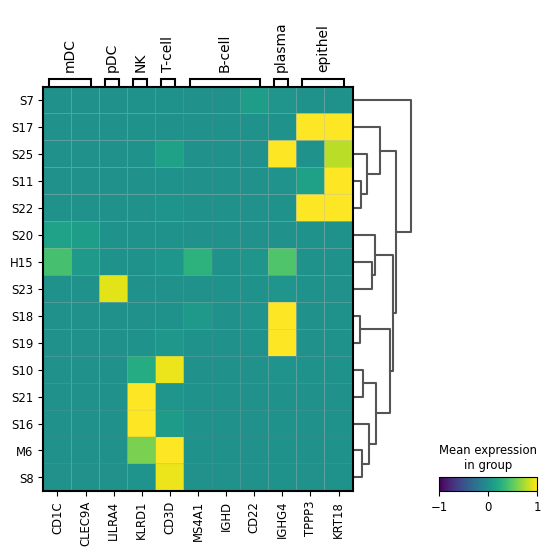

In [20]:
clustermap_marker_ = {
    'Group 1': ['S100A8', 'FCN1','CD14'],
    'Group 2':['CCL2', 'CCL3', 'CXCL10'],
    'Group 1-2':['STAT1','STAT2'],
    'Group 3':['SPP1','A2M', 'GPR183','CCL13','CREB1','TFEB','NR1H3', 'PPARA'],
    'Group 4':['FABP4','APOC1', 'MARCO','PPARG', 'CEBPB']
}
clustermap_marker_genes = {
    'Healthy':['FABP4'],
    'Moderate': ['FABP4'],
    'Severe':['FCN1','SPP1','TFEB','PPARG', 'CEBPB','CREB1','NR1H3', 'PPARA']
}

# marker genes for non-macrophage clusters 
marker_genes = { 
    "mDC": ['CD1C', 'CLEC9A'],
    "pDC": ['LILRA4'],
    "NK": ['KLRD1'],
    'T-cell': ['CD3D'],
    'B-cell': ['MS4A1','IGHD', 'CD22'],
    'plasma': ['IGHG4'],  # CD19 doesnt show up for B
    'epithel': ['TPPP3', 'KRT18']
}

ann_data.obs['macrophage'] = ann_data.raw[:, 'CD68'].X.toarray()

df_adata = pd.DataFrame(ann_data.X, columns = [i for i in list(ann_data.var_names)])
df_adata['parc'] = [i for i in ann_data.obs['parc']]
df_adata['cd68'] = [i for i in ann_data.obs['macrophage']] #CD68 is not in the filtered HVG genes, but in adata.RAW 

df_adata = df_adata.groupby('parc', as_index=False).mean()
df_adata['macrophage'] = df_adata['cd68'] > (np.mean(df_adata['cd68']+0.2*np.std(df_adata['cd68'])))

macrophage_cluster_list = df_adata[df_adata['macrophage']==True]['parc'].values

patient_health_list = [i for i in ann_data.obs['patient_health']]
parc_health = np.empty([len(parc_model.y_data_pred), 1], dtype=object)
health_dict = {"H":[], "S":[], "M":[]}
for i in set(parc_model.y_data_pred):
    loc_i = np.where(np.asarray(parc_model.y_data_pred)==i)[0]
    ll= list(np.asarray(patient_health_list)[loc_i])
    mode_i = max(set(ll), key=ll.count)
  
    if mode_i == 'S':
        parc_health[loc_i] = 'S'+str(i)
        health_dict["S"].append(i)
    elif mode_i == 'M':
        parc_health[loc_i] = 'M'+str(i)
        health_dict["M"].append(i)
    elif mode_i == 'H':
        parc_health[loc_i] = 'H'+str(i)
        health_dict["H"].append(i)

parc_health = list(parc_health.flatten())

ann_data.obs['health_parc'] = [str(i) for i in parc_health]
macrophage_cluster_bool = []
for i in parc_model.y_data_pred:
    if str(i) in macrophage_cluster_list:
        macrophage_cluster_bool.append(True)
    else:
        macrophage_cluster_bool.append(False)

ann_data.obs['macro_clus'] = macrophage_cluster_bool
adata_macro = ann_data[ann_data.obs['macro_clus']==True]
adata_not_macro = ann_data[ann_data.obs['macro_clus']!=True]

new_health_parc = [i for i in adata_macro.obs['health_parc']]

sc.pl.matrixplot(
    adata_macro,
    clustermap_marker_genes,
    groupby='health_parc',
    vmax=1,
    vmin=-1,
    dendrogram=True
)
sc.pl.matrixplot(
    adata_not_macro,
    marker_genes,
    groupby='health_parc',
    vmax=1,
    vmin=-1,
    dendrogram=True
)

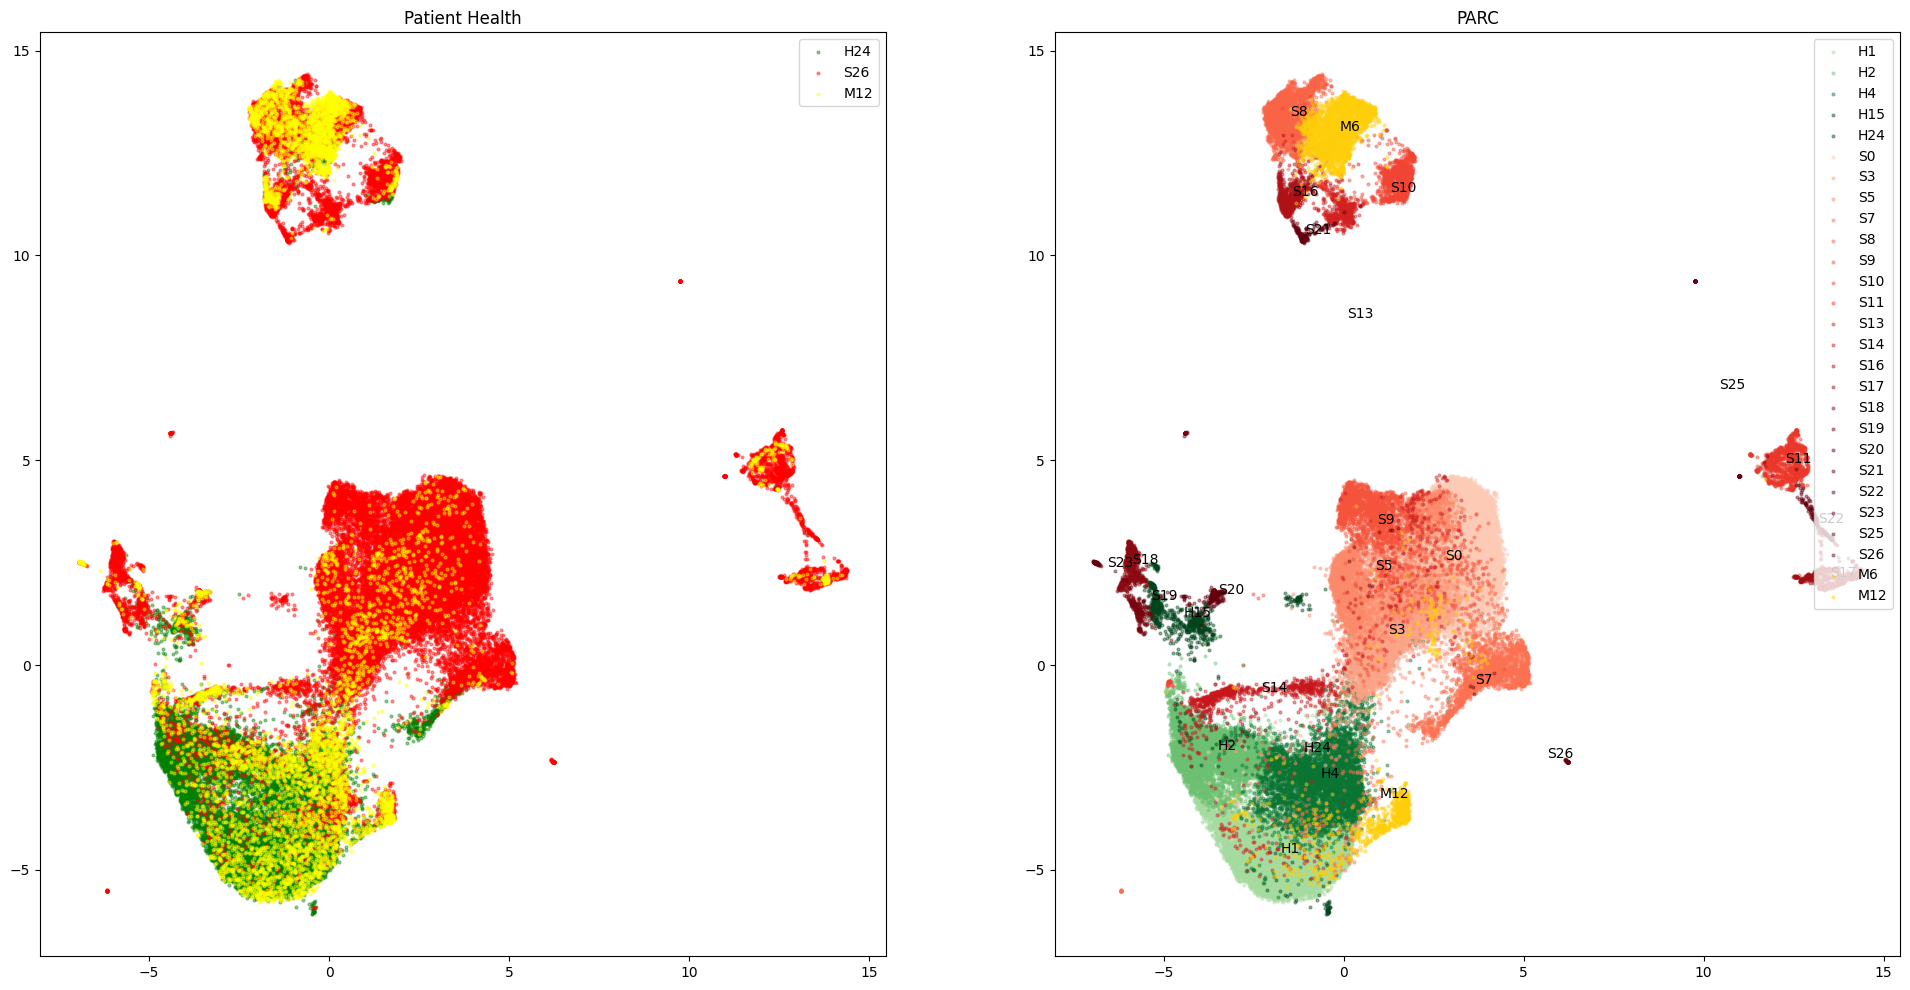

In [21]:
color_views = ['FCN1','SPP1','FABP4']

fig, axs = plt.subplots(1, 2, figsize=(24, 12))
axs[0].set_title("Patient Health")
axs[1].set_title("PARC")

color_dict = {"H":'Green',"S":'Red',"M":'Yellow'}

cmaps = {
    'S': colors.LinearSegmentedColormap.from_list(
        'name', plt.get_cmap('Reds')(np.linspace(0.2, 1, 100))
    ),
    'H': colors.LinearSegmentedColormap.from_list(
        'name', plt.get_cmap('Greens')(np.linspace(0.2, 1, 100))
    ),
    'M': colors.LinearSegmentedColormap.from_list(
        'name', plt.get_cmap("Wistia")(np.linspace(0.1, 0.4, 100))
    )
}

dict_color = {}
for key, uniq in health_dict.items():
    cnorm = colors.Normalize(vmin=0, vmax=len(uniq))
    scalar_map = cmx.ScalarMappable(norm=cnorm, cmap=cmaps[key])

    for i in uniq:
        indx = ann_data.obs['parc'] == str(i)
        axs[1].scatter(
            umap_embedding[indx, 0],
            umap_embedding[indx, 1],
            color=scalar_map.to_rgba(i),
            label=key+str(i),
            alpha=0.4,
            s=4
        )
        
        axs[1].text(np.mean(umap_embedding[indx,0]),np.mean(umap_embedding[indx,1]), key + str(i))
        axs[1].legend()

    indx = ann_data.obs['patient_health'] == key
    axs[0].scatter(
        umap_embedding[indx,0],
        umap_embedding[indx,1],
        color=color_dict[key],
        label=key + str(i),
        alpha=0.4,
        s=4
    )
    axs[0].legend()
plt.show()


### Expression of macrophage marker genes

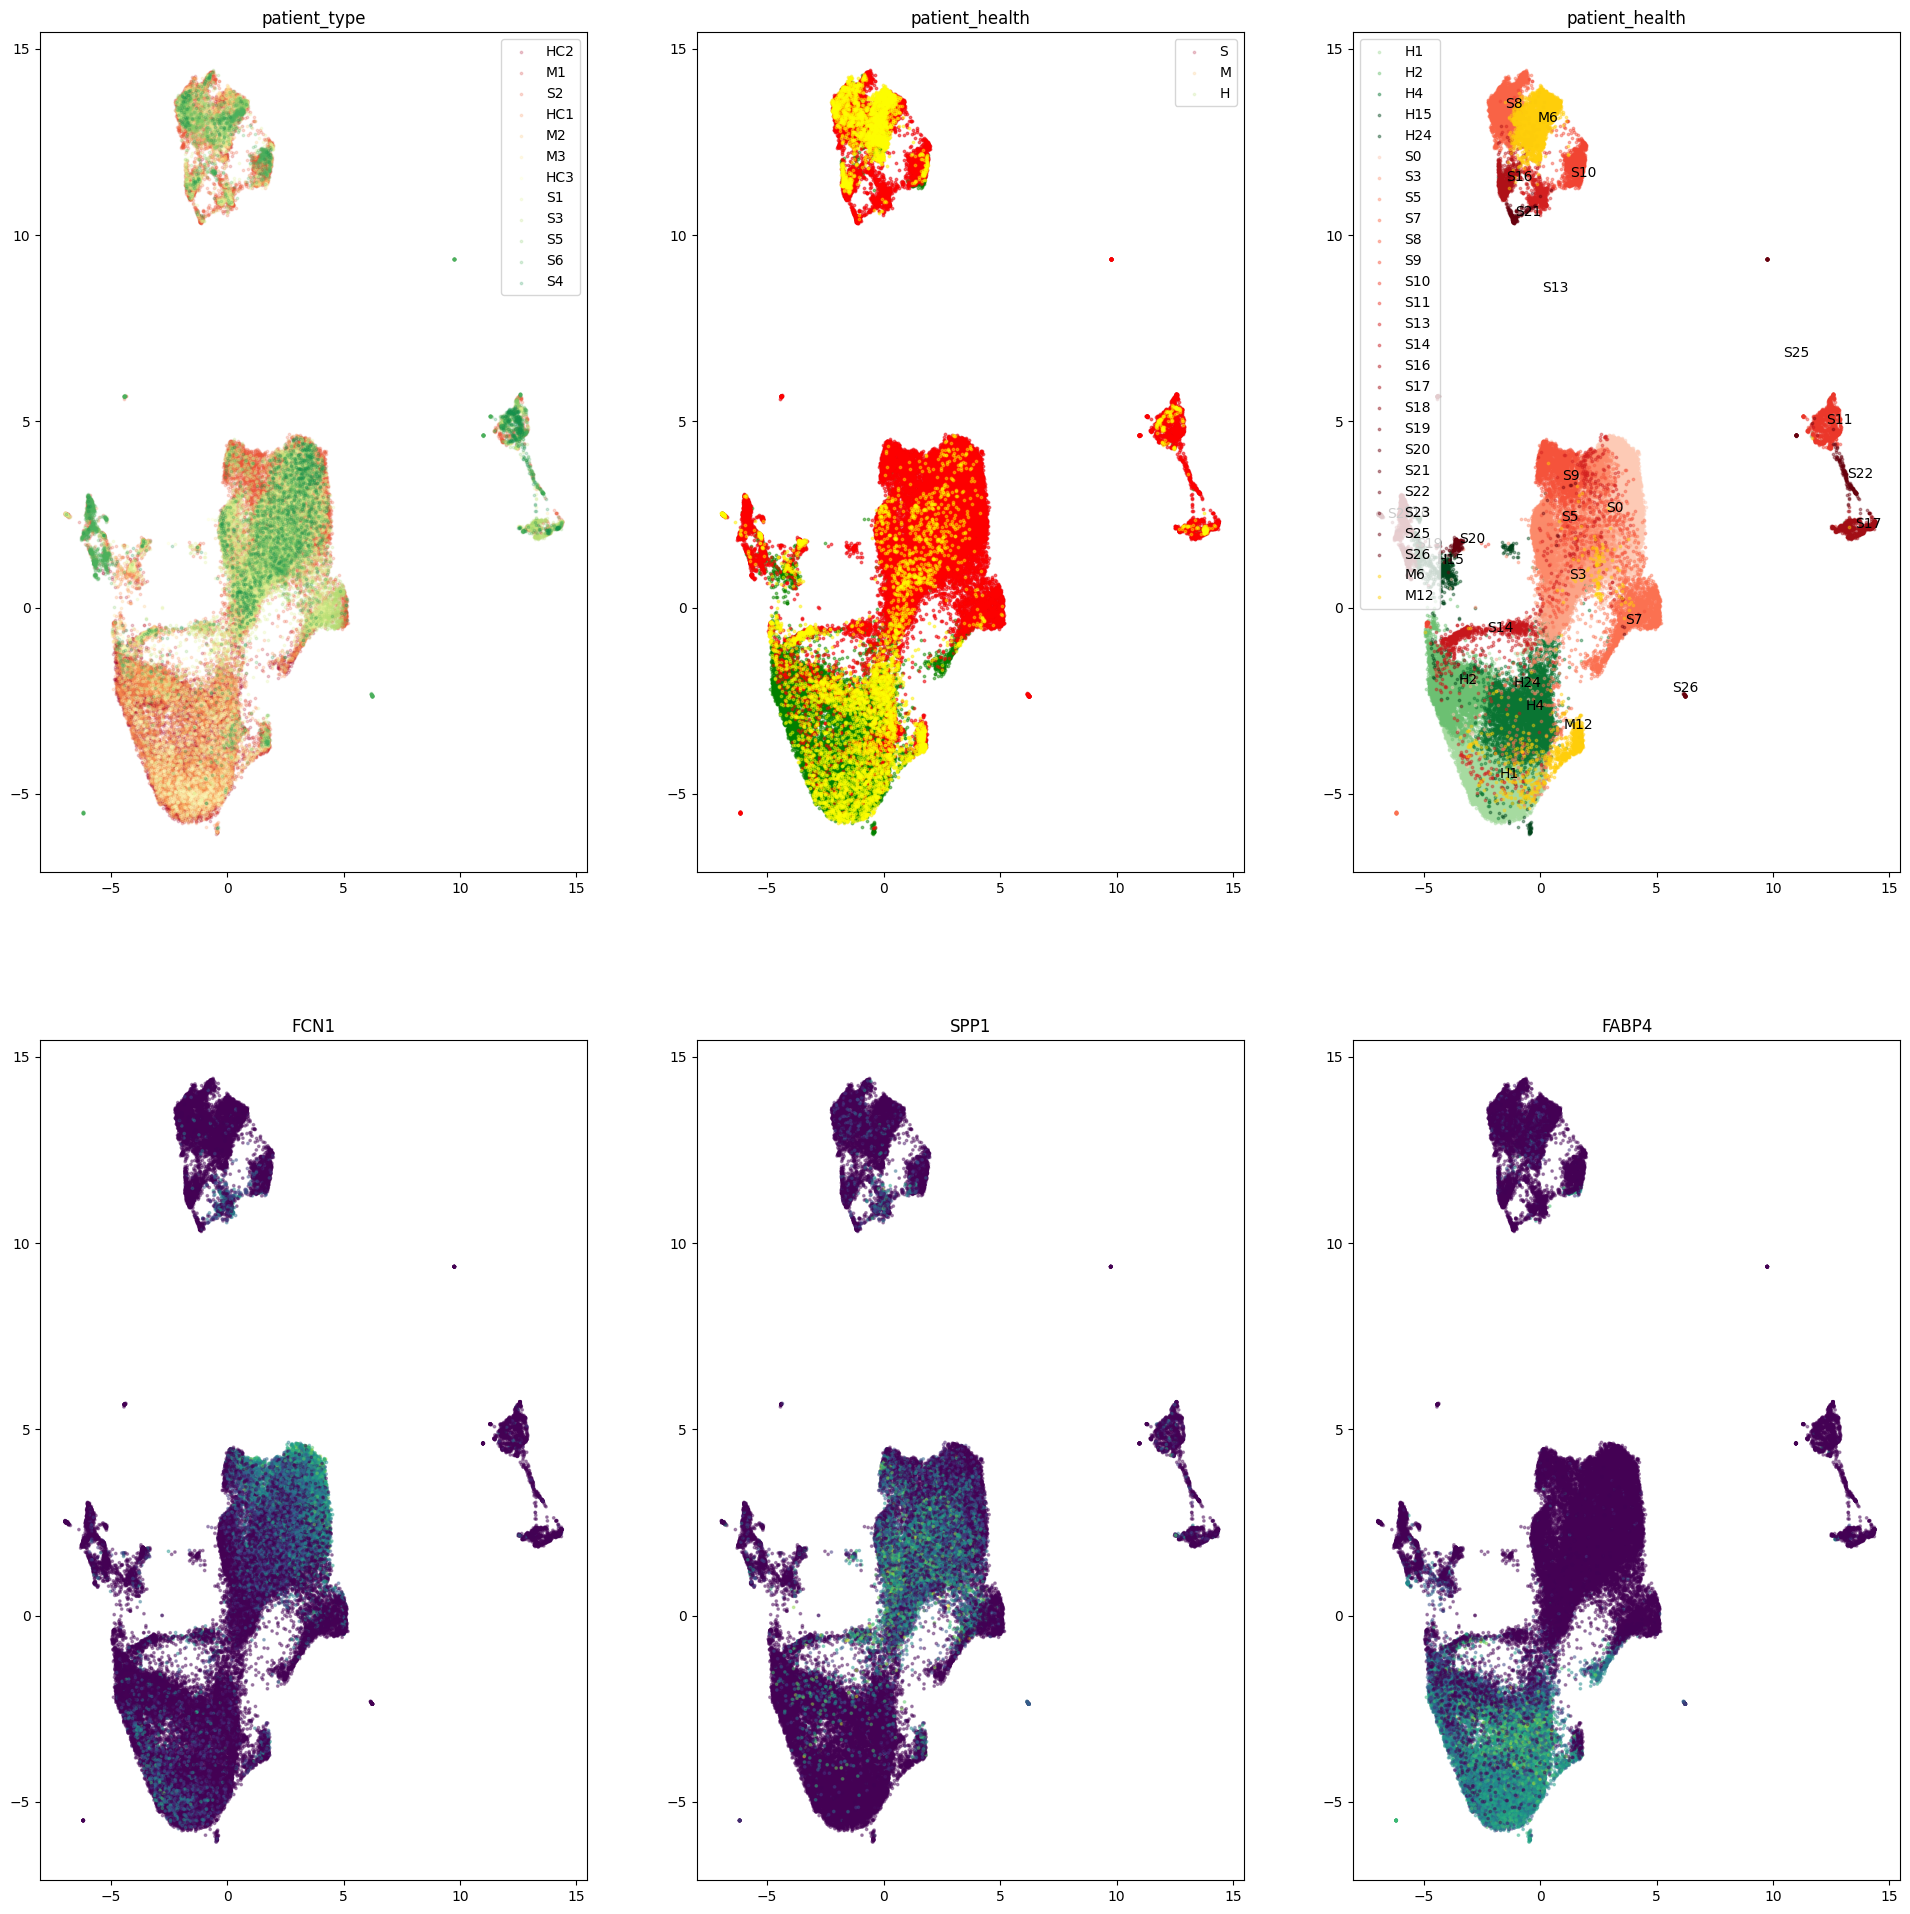

In [23]:
color_views = ['FCN1', 'SPP1', 'FABP4']

fig, axs = plt.subplots(2,3 ,figsize=(24,24))
for i in range(3):
    axs[1,i].scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1],
        c=ann_data[:, color_views[i]].X.flatten(),
        alpha=0.4,
        s=3
    )
    axs[1, i].set_title(color_views[i])

color_views_categ = ['patient_type', 'patient_health', 'parc']
color_dict = {"H":'Green',"S":'Red',"M":'Yellow'}

for i_ax in range(2):
    uniq = list(set(ann_data.obs[color_views_categ[i_ax]]))
    # Set the color map to match the number of species
    cnorm = colors.Normalize(vmin=0, vmax=len(uniq))
    scalar_map = cmx.ScalarMappable(norm=cnorm, cmap='RdYlGn')
    # Plot each species
    for i in range(len(uniq)):
        indx = ann_data.obs[color_views_categ[i_ax]] == uniq[i]
        axs[0,i_ax].scatter(
            umap_embedding[indx,0],
            umap_embedding[indx,1],
            color=scalar_map.to_rgba(i),
            label=uniq[i],
            alpha=0.2,
            s=3
        )
    axs[0,i_ax].set_title(color_views_categ[i_ax])
    axs[0,i_ax].legend()
    

for key, uniq in health_dict.items():
    cnorm = colors.Normalize(vmin=0, vmax=len(uniq))
    scalar_map = cmx.ScalarMappable(norm=cnorm, cmap=cmaps[key])
    for i in uniq:
        indx = ann_data.obs['parc'] == str(i)
        axs[0,2].scatter(
            umap_embedding[indx, 0],
            umap_embedding[indx, 1],
            color=scalar_map.to_rgba(i),
            label=key+str(i),
            alpha=0.4,
            s=3
        )
        axs[0,2].set_title(color_views_categ[i_ax])
        axs[0,2].text(np.mean(umap_embedding[indx, 0]), np.mean(umap_embedding[indx, 1]),key+str(i))
        axs[0,2].legend()
    indx = ann_data.obs['patient_health'] == key
    axs[0,1].scatter(
        umap_embedding[indx, 0],
        umap_embedding[indx, 1],
        color=color_dict[key],
        label=key+str(i),
        alpha=0.4,
        s=3
    )
plt.show()
